In [21]:
# Import general modules used e.g. for plotting.
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import sys
import torch

# Importing Hopfield-specific modules.
# from hflayers import Hopfield, HopfieldPooling, HopfieldLayer
from datasets.synthetic import BitPatternSet
from layers import *
from tqdm.notebook import trange, tqdm

# Import auxiliary modules.
from distutils.version import LooseVersion
from typing import List, Tuple

# Importing PyTorch specific modules.
from torch import Tensor
from torch.nn import Flatten, Linear, Module, Sequential
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW, Adam, SGD
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# Set plotting style.
sns.set()

In [22]:
log_dir = f'resources/'
os.makedirs(log_dir, exist_ok=True)

In [23]:
device = torch.device(r'cuda:0' if torch.cuda.is_available() else r'cpu')

In [24]:
def train_epoch(network: Module,
                optimiser: AdamW,
                data_loader: DataLoader
               ) -> Tuple[float, float]:
    """
    Execute one training epoch.
    
    :param network: network instance to train
    :param optimiser: optimiser instance responsible for updating network parameters
    :param data_loader: data loader instance providing training data
    :return: tuple comprising training loss as well as accuracy
    """
    network.train()
    losses, accuracies = [], []
    for sample_data in data_loader:
        data, target = sample_data[r'data'], sample_data[r'target']
        data, target = data.to(device=device), target.to(device=device)

        # Process data by Hopfield-based network.
        model_output = network.forward(data)

        # Update network parameters.
        optimiser.zero_grad()
        loss = binary_cross_entropy_with_logits(input=model_output, target=target, reduction=r'mean')
        loss.backward()
        clip_grad_norm_(parameters=network.parameters(), max_norm=1.0, norm_type=2)
        optimiser.step()

        # Compute performance measures of current model.
        accuracy = (model_output.sigmoid().round() == target).to(dtype=torch.float32).mean()
        accuracies.append(accuracy.detach().item())
        losses.append(loss.detach().item())
    
    # Report progress of training procedure.
    return (sum(losses) / len(losses), sum(accuracies) / len(accuracies))


def eval_iter(network: Module,
              data_loader: DataLoader
             ) -> Tuple[float, float]:
    """
    Evaluate the current model.
    
    :param network: network instance to evaluate
    :param data_loader: data loader instance providing validation data
    :return: tuple comprising validation loss as well as accuracy
    """
    network.eval()
    with torch.no_grad():
        losses, accuracies = [], []
        for sample_data in data_loader:
            data, target = sample_data[r'data'], sample_data[r'target']
            data, target = data.to(device=device), target.to(device=device)

            # Process data by Hopfield-based network.
            model_output = network.forward(data)
            loss = binary_cross_entropy_with_logits(input=model_output, target=target, reduction=r'mean')

            # Compute performance measures of current model.
            accuracy = (model_output.sigmoid().round() == target).to(dtype=torch.float32).mean()
            accuracies.append(accuracy.detach().item())
            losses.append(loss.detach().item())

        # Report progress of validation procedure.
        return (sum(losses) / len(losses), sum(accuracies) / len(accuracies))


def operate(network: Module,
            optimiser: AdamW,
            data_loader_train: DataLoader,
            data_loader_eval: DataLoader,
            num_epochs: int = 1
           ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Train the specified network by gradient descent using backpropagation.
    
    :param network: network instance to train
    :param optimiser: optimiser instance responsible for updating network parameters
    :param data_loader_train: data loader instance providing training data
    :param data_loader_eval: data loader instance providing validation data
    :param num_epochs: amount of epochs to train
    :return: data frame comprising training as well as evaluation performance
    """
    losses, accuracies = {r'train': [], r'eval': []}, {r'train': [], r'eval': []}
    for epoch in range(num_epochs):
        
        # Train network.
        performance = train_epoch(network, optimiser, data_loader_train)
        losses[r'train'].append(performance[0])
        accuracies[r'train'].append(performance[1])
        
        # Evaluate current model.
        performance = eval_iter(network, data_loader_eval)
        losses[r'eval'].append(performance[0])
        accuracies[r'eval'].append(performance[1])
    
    # Report progress of training and validation procedures.
    return pd.DataFrame(losses), pd.DataFrame(accuracies)

In [25]:
def set_seed(seed: int = 42) -> None:
    """
    Set seed for all underlying (pseudo) random number sources.
    
    :param seed: seed to be used
    :return: None
    """
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def plot_performance(loss: pd.DataFrame,
                     accuracy: pd.DataFrame,
                     log_file: str
                    ) -> None:
    """
    Plot and save loss and accuracy.
    
    :param loss: loss to be plotted
    :param accuracy: accuracy to be plotted
    :param log_file: target file for storing the resulting plot
    :return: None
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    
    loss_plot = sns.lineplot(data=loss, ax=ax[0])
    loss_plot.set(xlabel=r'Epoch', ylabel=r'Cross-entropy Loss')
    
    accuracy_plot = sns.lineplot(data=accuracy, ax=ax[1])
    accuracy_plot.set(xlabel=r'Epoch', ylabel=r'Accuracy')
    
    ax[1].yaxis.set_label_position(r'right')
    fig.tight_layout()
    fig.savefig(log_file)
    plt.show(fig)

In [26]:
from models import BITModel

In [27]:
def get_data(num_instances, num_signals_per_bag=1):

    bit_pattern_set = BitPatternSet(
        num_bags=2048,
        num_instances=num_instances,
        num_signals=8,
        num_signals_per_bag=num_signals_per_bag,
        num_bits=16)
    # Create data loader of training set.
    sampler_train = SubsetRandomSampler(list(range(256, 2048 - 256)))
    data_loader_train = DataLoader(dataset=bit_pattern_set, batch_size=32, sampler=sampler_train)

    # Create data loader of validation set.
    sampler_eval = SubsetRandomSampler(list(range(256)) + list(range(2048 - 256, 2048)))
    data_loader_eval = DataLoader(dataset=bit_pattern_set, batch_size=32, sampler=sampler_eval)
    
    return bit_pattern_set, data_loader_train, data_loader_eval

In [28]:
def softmax_run(num_instances):

    bit_pattern_set, data_loader_train, data_loader_eval = get_data(num_instances=num_instances)

    set_seed(torch.random.seed())
    network = BITModel(
        input_size=bit_pattern_set.num_bits, 
        d_model=bit_pattern_set.num_bits, 
        n_heads=1, 
        update_steps=1, 
        scale=0.1, 
        dropout=0.1,
        num_pattern=2,
        mode='softmax').cuda()
    optimiser = Adam(params=network.parameters(), lr=1e-5, weight_decay=0.0)

    losses, accuracies = operate(
        network=network,
        optimiser=optimiser,
        data_loader_train=data_loader_train,
        data_loader_eval=data_loader_eval,
        num_epochs=200)
    plot_performance(loss=losses, accuracy=accuracies, log_file=f'{log_dir}/dense.pdf')

def sparsemax_run(num_instances):

    bit_pattern_set, data_loader_train, data_loader_eval = get_data(num_instances=num_instances)

    set_seed(torch.random.seed())
    network = BITModel(
        input_size=bit_pattern_set.num_bits, 
        d_model=bit_pattern_set.num_bits, 
        n_heads=1, 
        update_steps=1, 
        scale=0.1, 
        dropout=0.1,
        num_pattern=2,
        mode='sparsemax').cuda()
    optimiser = Adam(params=network.parameters(), lr=1e-5, weight_decay=0.0)

    losses, accuracies = operate(
        network=network,
        optimiser=optimiser,
        data_loader_train=data_loader_train,
        data_loader_eval=data_loader_eval,
        num_epochs=200)
    plot_performance(loss=losses, accuracy=accuracies, log_file=f'{log_dir}/sparse.pdf')

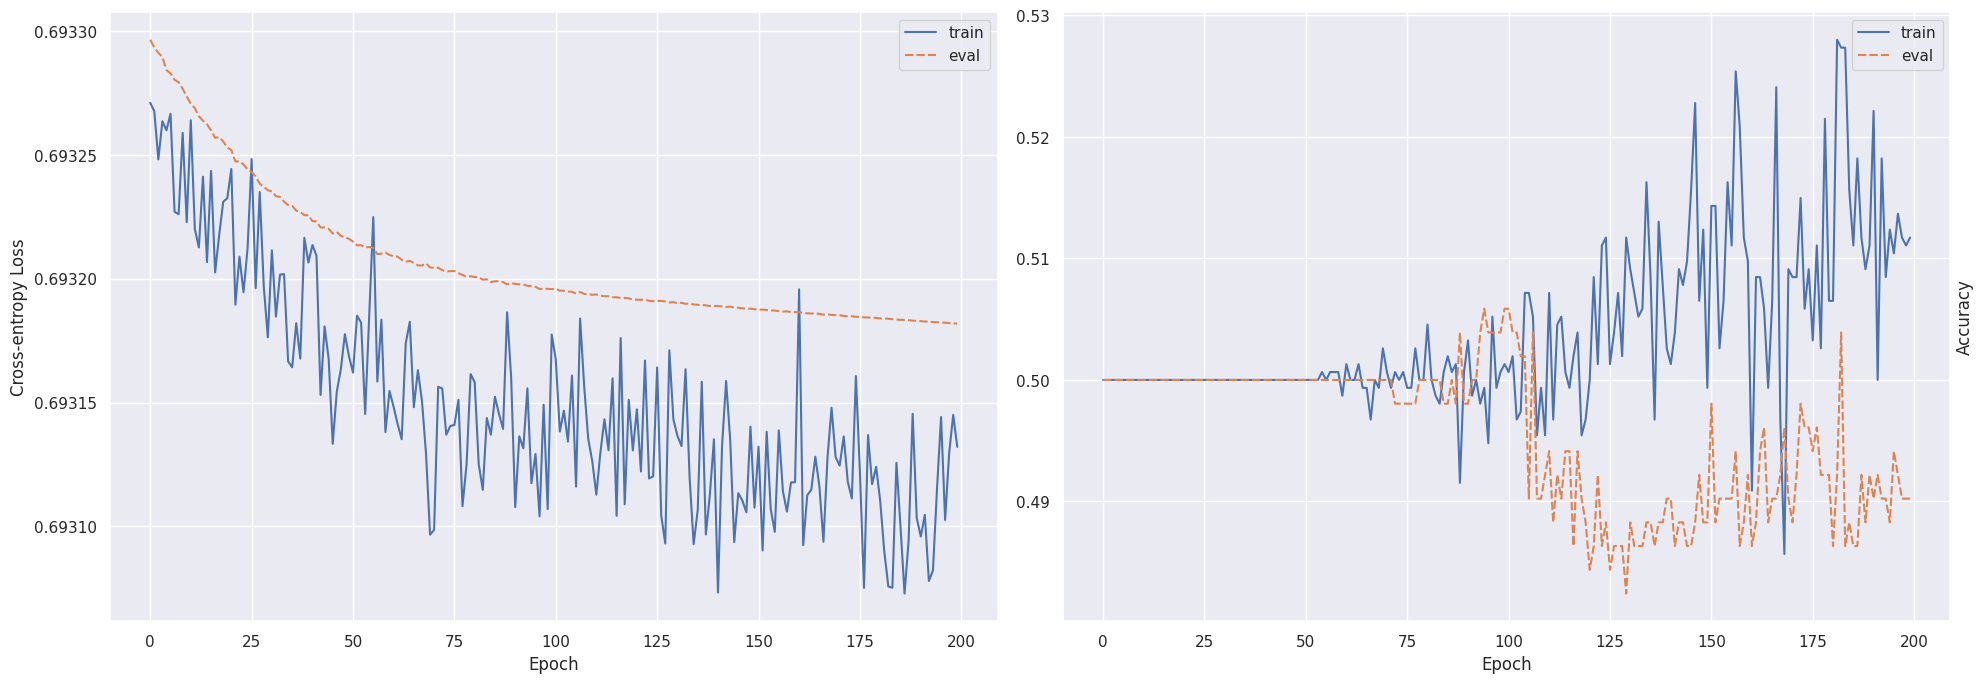

In [29]:
bag_sizes = [10, 20, 50, 100, 200, 300, 500, 1000, 2000]
trials = 10
sparsemax_run(100)

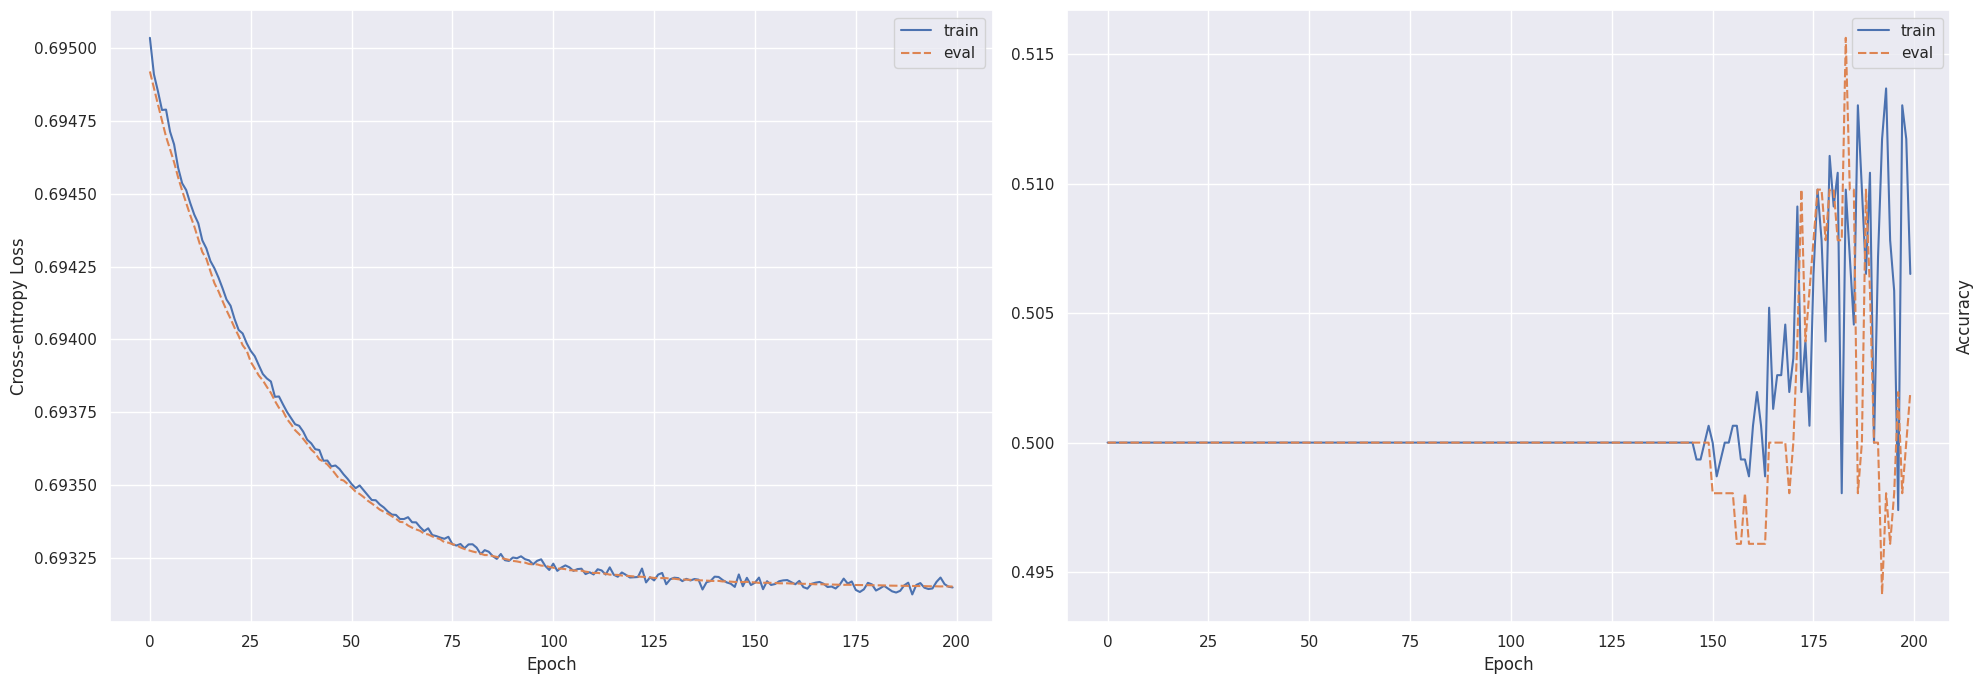

In [30]:
softmax_run(100)

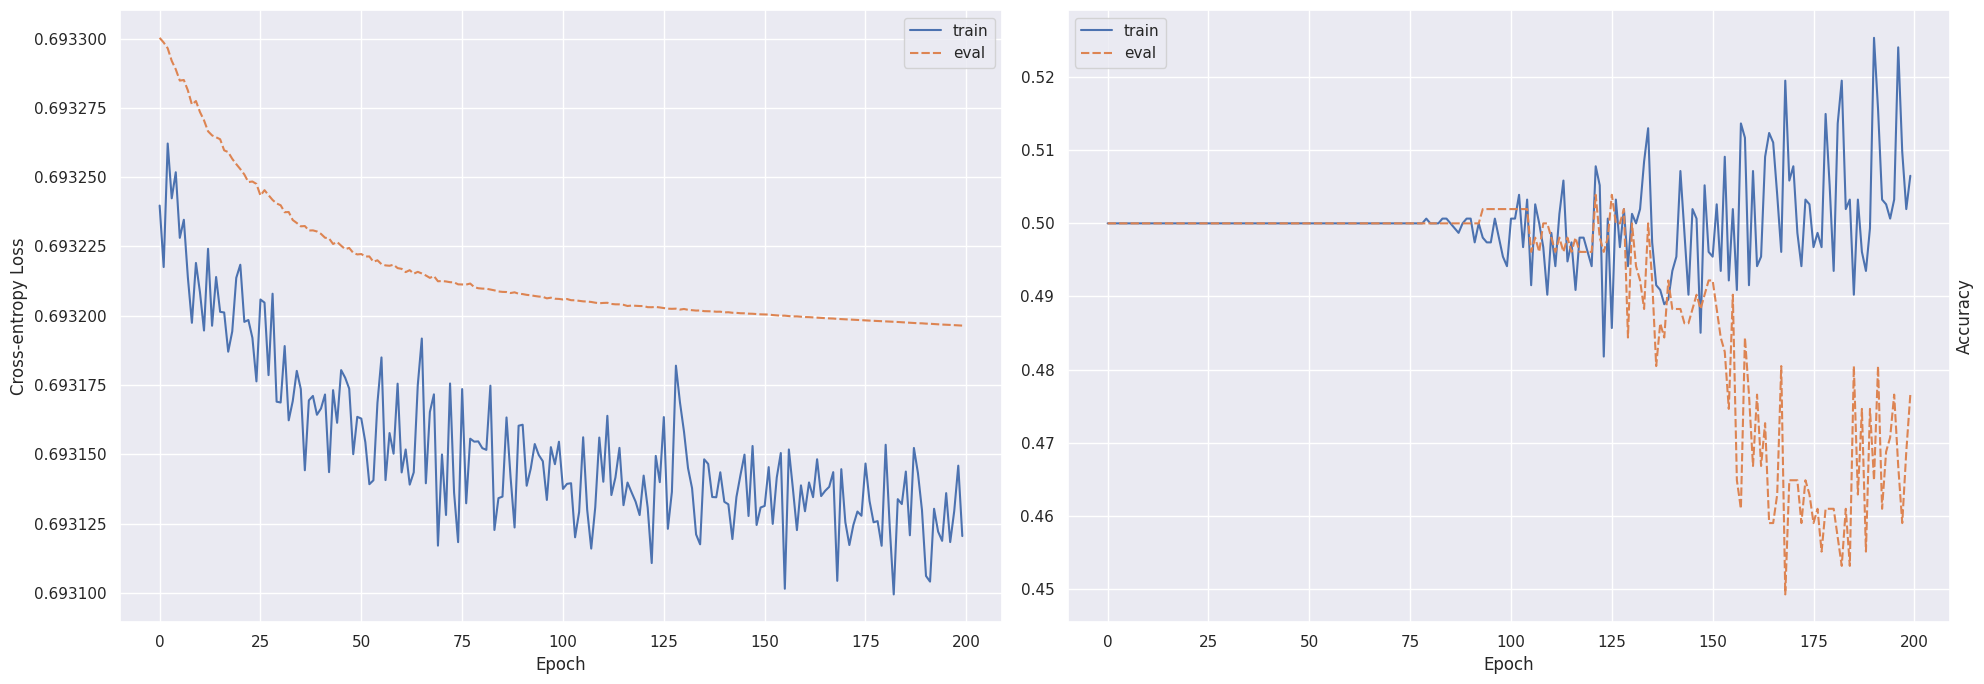

In [31]:
sparsemax_run(200)

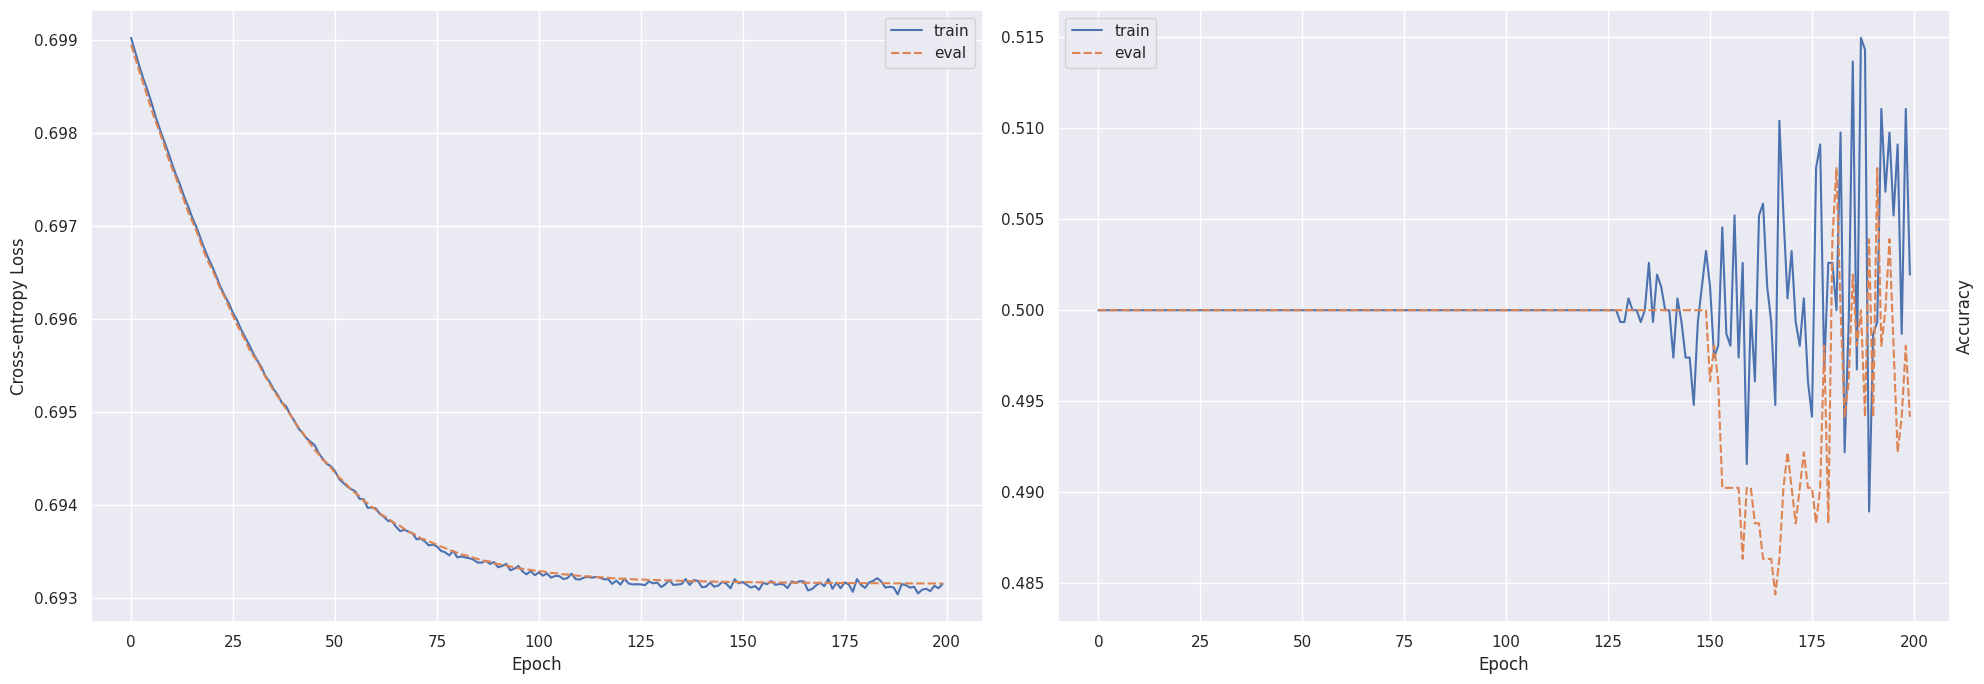

In [32]:
softmax_run(200)